In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dropout, GlobalMaxPool1D, Embedding, Dense, InputLayer, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from matplotlib import pyplot as plt
from IPython import display
import soundfile as sf
from keras.models import load_model
from sklearn.metrics import top_k_accuracy_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
SAMPLING_RATE = 22050

In [3]:
data = tf.keras.utils.audio_dataset_from_directory('./data', seed=7, batch_size=1000)

Found 999 files belonging to 10 classes.


In [4]:
class_names = data.class_names
class_names

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [5]:
X = []
y = []

for (x, l) in data.as_numpy_iterator():
    X = x
    y = l

In [7]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=27)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, stratify=y_test_val, test_size=0.6, random_state=27)

In [8]:
import random

In [39]:
def splitting_data(X,y):
    newX = []
    newY = []

    X_len = X[0].shape[0]
    res = X_len%5
  
    n = X.shape[0]
    for i in range(n):
        X_pom = X[i][:-(res)]
        pom = np.split(X_pom,5)
        newX.append(pom[random.randint(0,4)][:])
    return np.array(newX), y

In [40]:
newX_test, newy_test = splitting_data(X_test,y_test)
newX_val, newy_val = splitting_data(X_val, y_val)

In [11]:
newX_test.shape

(120, 135161, 1)

In [12]:
newy_test.shape

(120,)

## Loading and comparing trained Conv1D models

In [13]:
model_1 = load_model('./1D_Conv_models/model-0.01rate.h5')
model_2 = load_model('./1D_Conv_models/model-0.001rate.h5')
model_3 = load_model('./1D_Conv_models/model-0.0001rate.h5')

In [14]:
top_3_array = []
acc_array = []

In [15]:
def accuracy_fun(model):
    y_pred_prob = model.predict(newX_val)
    top3 = top_k_accuracy_score(newy_val, y_pred_prob,k=3)
    top_3_array.append(top3)
    print(f"Top_3_accuracy: {top3}")
    acc = accuracy_score(newy_val, [np.argmax(x) for x in y_pred_prob] )
    acc_array.append(acc)
    print(f"Classic accuracy: {acc}")

In [16]:
accuracy_fun(model_1)

6/6 [==============================] - 4s 536ms/step
Top_3_accuracy: 0.3
Classic accuracy: 0.1


In [17]:
accuracy_fun(model_2)

6/6 [==============================] - 3s 507ms/step
Top_3_accuracy: 0.8444444444444444
Classic accuracy: 0.5944444444444444


In [18]:
accuracy_fun(model_3)

6/6 [==============================] - 3s 510ms/step
Top_3_accuracy: 0.7222222222222222
Classic accuracy: 0.38333333333333336


In [19]:
top_3_array

[0.3, 0.8444444444444444, 0.7222222222222222]

In [20]:
acc_array

[0.1, 0.5944444444444444, 0.38333333333333336]

In [21]:
labels = ["model_0.01rate", "model_0.001rate", "model_0.0001rate"]

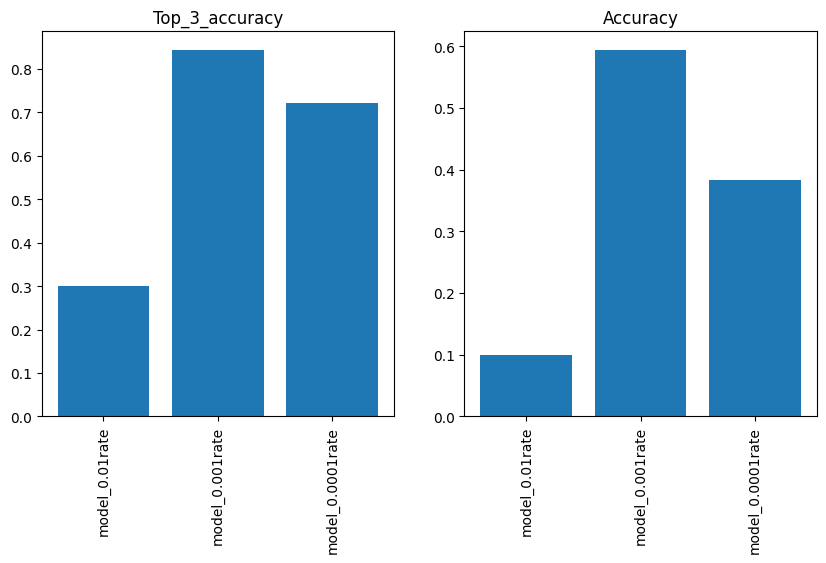

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar([0,1,2],top_3_array)
plt.xticks([0,1,2],labels=labels, rotation=90)
plt.title("Top_3_accuracy")

plt.subplot(1,2,2)
plt.bar([0,1,2],acc_array)
plt.xticks([0,1,2],labels=labels, rotation=90)
plt.title("Accuracy")

plt.show()

Based on previous results and plots we can see that model with a learning rate of 0.001 gives best results, so that is the model that will be evaluated on test data.

## Evaluation of winning model

In [23]:
model = model_2

In [24]:
model_2.evaluate(newX_test)

4/4 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [25]:
y_prob = model.predict(newX_test)

4/4 [==============================] - 2s 496ms/step


In [26]:
y_prob

array([[2.58126054e-02, 3.89180221e-02, 6.53316081e-01, ...,
        2.87866183e-02, 4.43685614e-03, 7.56086707e-02],
       [1.85263574e-01, 1.64913192e-01, 3.01638365e-01, ...,
        2.73233652e-02, 6.12275023e-03, 1.09179676e-01],
       [3.58598121e-02, 2.59110511e-05, 8.33128035e-01, ...,
        2.34660301e-02, 1.57167707e-02, 5.74440416e-03],
       ...,
       [7.28077866e-05, 6.55010495e-18, 1.77687086e-12, ...,
        5.70067755e-07, 1.61709636e-02, 2.50157317e-08],
       [5.42593988e-08, 8.69811997e-24, 8.32449127e-12, ...,
        5.85901551e-04, 3.08075309e-04, 1.40520640e-07],
       [3.90746929e-02, 1.80508956e-01, 2.15199441e-02, ...,
        1.84914730e-02, 2.04439983e-02, 3.81625840e-03]], dtype=float32)

In [27]:
top_3_res = top_k_accuracy_score(newy_test, y_prob,k=3)
top_3_res

0.8666666666666667

In [28]:
acc_3_res = accuracy_score(newy_test, [np.argmax(x) for x in y_prob] )
acc_3_res

0.6

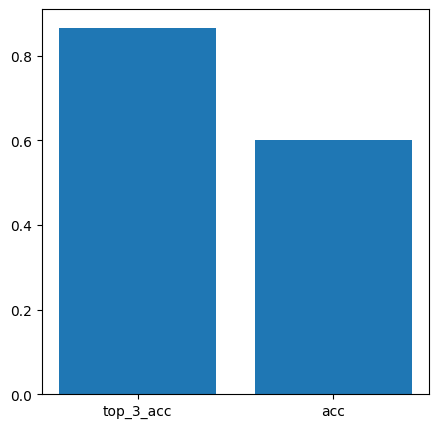

In [53]:
plt.figure(figsize=(5,5))
plt.bar([0,1],[top_3_res,acc_3_res])
plt.xticks([0,1],labels=['top_3_acc','acc'])
plt.show()

Accuracy by itself is not that great, but with top_3_accuracy_score we can see that model predicts true class of instance in first 3 top predictions scores, with accuracy of 0.867

In [29]:
class_names

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [30]:
conf_matrix = confusion_matrix(newy_test,[np.argmax(x) for x in y_prob])
conf_matrix

array([[ 4,  1,  1,  0,  0,  3,  2,  0,  0,  1],
       [ 0,  8,  2,  0,  0,  2,  0,  0,  0,  0],
       [ 1,  0,  7,  0,  0,  1,  0,  0,  0,  3],
       [ 1,  1,  0,  7,  0,  0,  1,  1,  0,  1],
       [ 0,  1,  0,  0,  8,  0,  0,  1,  1,  1],
       [ 1,  0,  1,  0,  0, 10,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 11,  0,  0,  0],
       [ 0,  1,  0,  1,  3,  0,  0,  7,  0,  0],
       [ 1,  0,  0,  0,  1,  1,  0,  1,  8,  0],
       [ 0,  0,  1,  1,  1,  3,  3,  1,  0,  2]], dtype=int64)

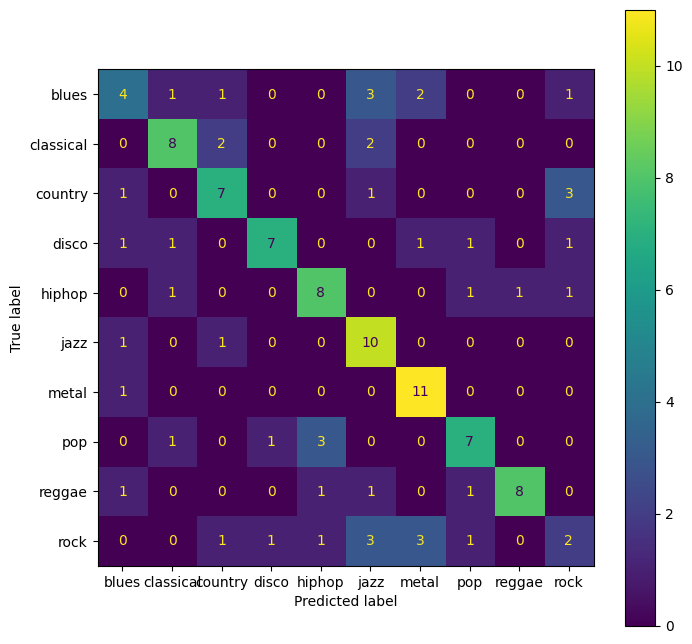

In [52]:
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
display_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
display_matrix.plot(ax=ax)

The highest values are on the diagonal, which means that this model has good predictions.

Most missclassifications are for class 'rock' and from confusion matrix we can conclude that model can't recognize instances of this class.
Also, class 'blues' is mostly missclassified as 'jazz' and class 'pop' as 'hiphop'.


## Examples of missclassified instances

In [34]:
def play_sound(x):
    sf.write("./preview_data/test_sound.wav",x,SAMPLING_RATE)
    display.display(display.Audio("./preview_data/test_sound.wav"))

In [35]:
missclassified = []
for i in range(len(y_prob)):
    if np.argmax(y_prob[i])!=newy_test[i]:
        missclassified.append(i)


In [36]:
n = len(missclassified)
ind = [missclassified[x] for x in np.random.randint(n,size=10)]
for i in ind:
    print(f"Predicted genre: {class_names[np.argmax(y_prob[i])]} ({np.max(y_prob[i]*100):.4}%)")
    print(f"True genre: {class_names[newy_test[i]]}")
    play_sound(newX_test[i])

Predicted genre: rock (65.06%)
True genre: country


Predicted genre: jazz (68.86%)
True genre: rock


Predicted genre: hiphop (47.92%)
True genre: rock


Predicted genre: metal (83.7%)
True genre: rock


Predicted genre: jazz (68.86%)
True genre: rock


Predicted genre: metal (48.61%)
True genre: rock


Predicted genre: pop (60.18%)
True genre: reggae


Predicted genre: classical (72.11%)
True genre: pop


Predicted genre: jazz (50.13%)
True genre: classical


Predicted genre: pop (25.05%)
True genre: rock
